In [2]:
import numpy as np
import ProGED as pg
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import os
import sys
from ProGED.examples.DS2022.generate_data_ODE_systems import generate_ODE_data, lorenz, VDP
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d

In [3]:
problem = "vdp"

np.random.seed(0)

if problem == "lorenz":
    inits = [1,1,1]
    rho = 16
    f = lambda t, x: lorenz(t, x, rho=rho)
elif problem == "vdp":
    inits = [-0.2, -0.8]
    f = VDP

data = generate_ODE_data(f, inits)
T = data[:,0]
deltaT = T[1]-T[0]
X = data[:, 1:]
dX = np.array([np.gradient(Xi, deltaT) for Xi in X.T])

In [4]:
folder = "E:/Dropbox/github/PCFGproject/ProGED/examples/DS2022/results/numdiff/"
file = "numdiff_vdp_poly"
Neq = 2

In [5]:
models = [pg.ModelBox() for i in range(3)]
meantimes = []
for i in range(Neq):
    models[i].load(folder + file + "_eq" + str(i) + "_models_fit.pg")
    times = [m.get_time() for m in models[i]]
    meantimes += [np.mean(times)]
print(meantimes)

[3.5270656019886584, 3.3275900769183298]


In [6]:
def traj_err_1d(model, data, ind):
    inits = [-0.2, -0.8]
    lambf = model.lambdify(*model.params)
    def solutionf (t, x):
        y = [x[1], -0.5*x[0]**2*x[1] - 1*x[0] + 0.5*x[1]]
        y[ind] = lambf(*x)
        return y

    Yode, info = odeint(solutionf, inits, data[:,0],
                    rtol = 1e-12,
                    atol = 1e-12,
                    tfirst=True,
                    full_output=True)

    errs = []
    for i in range(len(inits)):
        errs += [np.sqrt(np.mean((Yode[:,i] - data[:,1:][:,i])**2))/np.std(data[:,i])]
    return np.sum(errs)

for i in range(Neq):
    for model in models[i]:
        err = traj_err_1d(model, data, i)
        if isinstance(err, float) and not np.isnan(err):
            model.estimated["fun"] = err
            model.estimated["err_type"] = "trajectory"
        else:
            model.estimated["err_type"] = "standard"

In [7]:
for i in range(Neq):
    print("----", i, "----")
    print(models[i].retrieve_best_models(5))

---- 0 ----
ModelBox: 5 models
-> -1.31103272246654e-5*x*y**2 + 6.76591317703629e-7*y**2 + 0.999987079520888*y, p = 2.8665446400000004e-07, parse trees = 1, valid = True, error = 0.00016256615168274232, time = 7.221548795700073
-> -1.21510806996409e-5*x*y**2 - 8.25674721785753e-7*x*y + 0.99998458836183*y, p = 2.8665446400000004e-07, parse trees = 1, valid = True, error = 0.00021363589664000936, time = 7.747906684875488
-> -1.21606560293343e-5*x*y**2 + 0.999984578847979*y, p = 0.00030725536481280007, parse trees = 13, valid = True, error = 0.0002139674422431953, time = 1.9807345867156982
-> 3.7542417588072e-7*x**2*y**2 - 1.22204895730192e-5*x*y**2 + 0.999984430014599*y, p = 1.1466178560000001e-08, parse trees = 1, valid = True, error = 0.00021632081223395177, time = 7.4550981521606445
-> 6.43618223878707e-7*x**4*y**3 - 1.32573473639033e-5*x*y**2 + 0.999982940107357*y, p = 9.172942848000005e-11, parse trees = 1, valid = True, error = 0.00021796797158955039, time = 10.135010004043579
----

In [8]:
succprob = []
curves = []
for i in range(Neq):
   # dat = np.hstack((dX[i].reshape((-1,1)), X))
    SRi, curvesx = pg.postprocessing.resample_curve(models[i], dX, target_variable_index=i, success_threshold=1e-3, resampleN=1000, process_error=False)
    succprob += [SRi/1000]
    curves += [np.mean(curvesx, axis=0)]

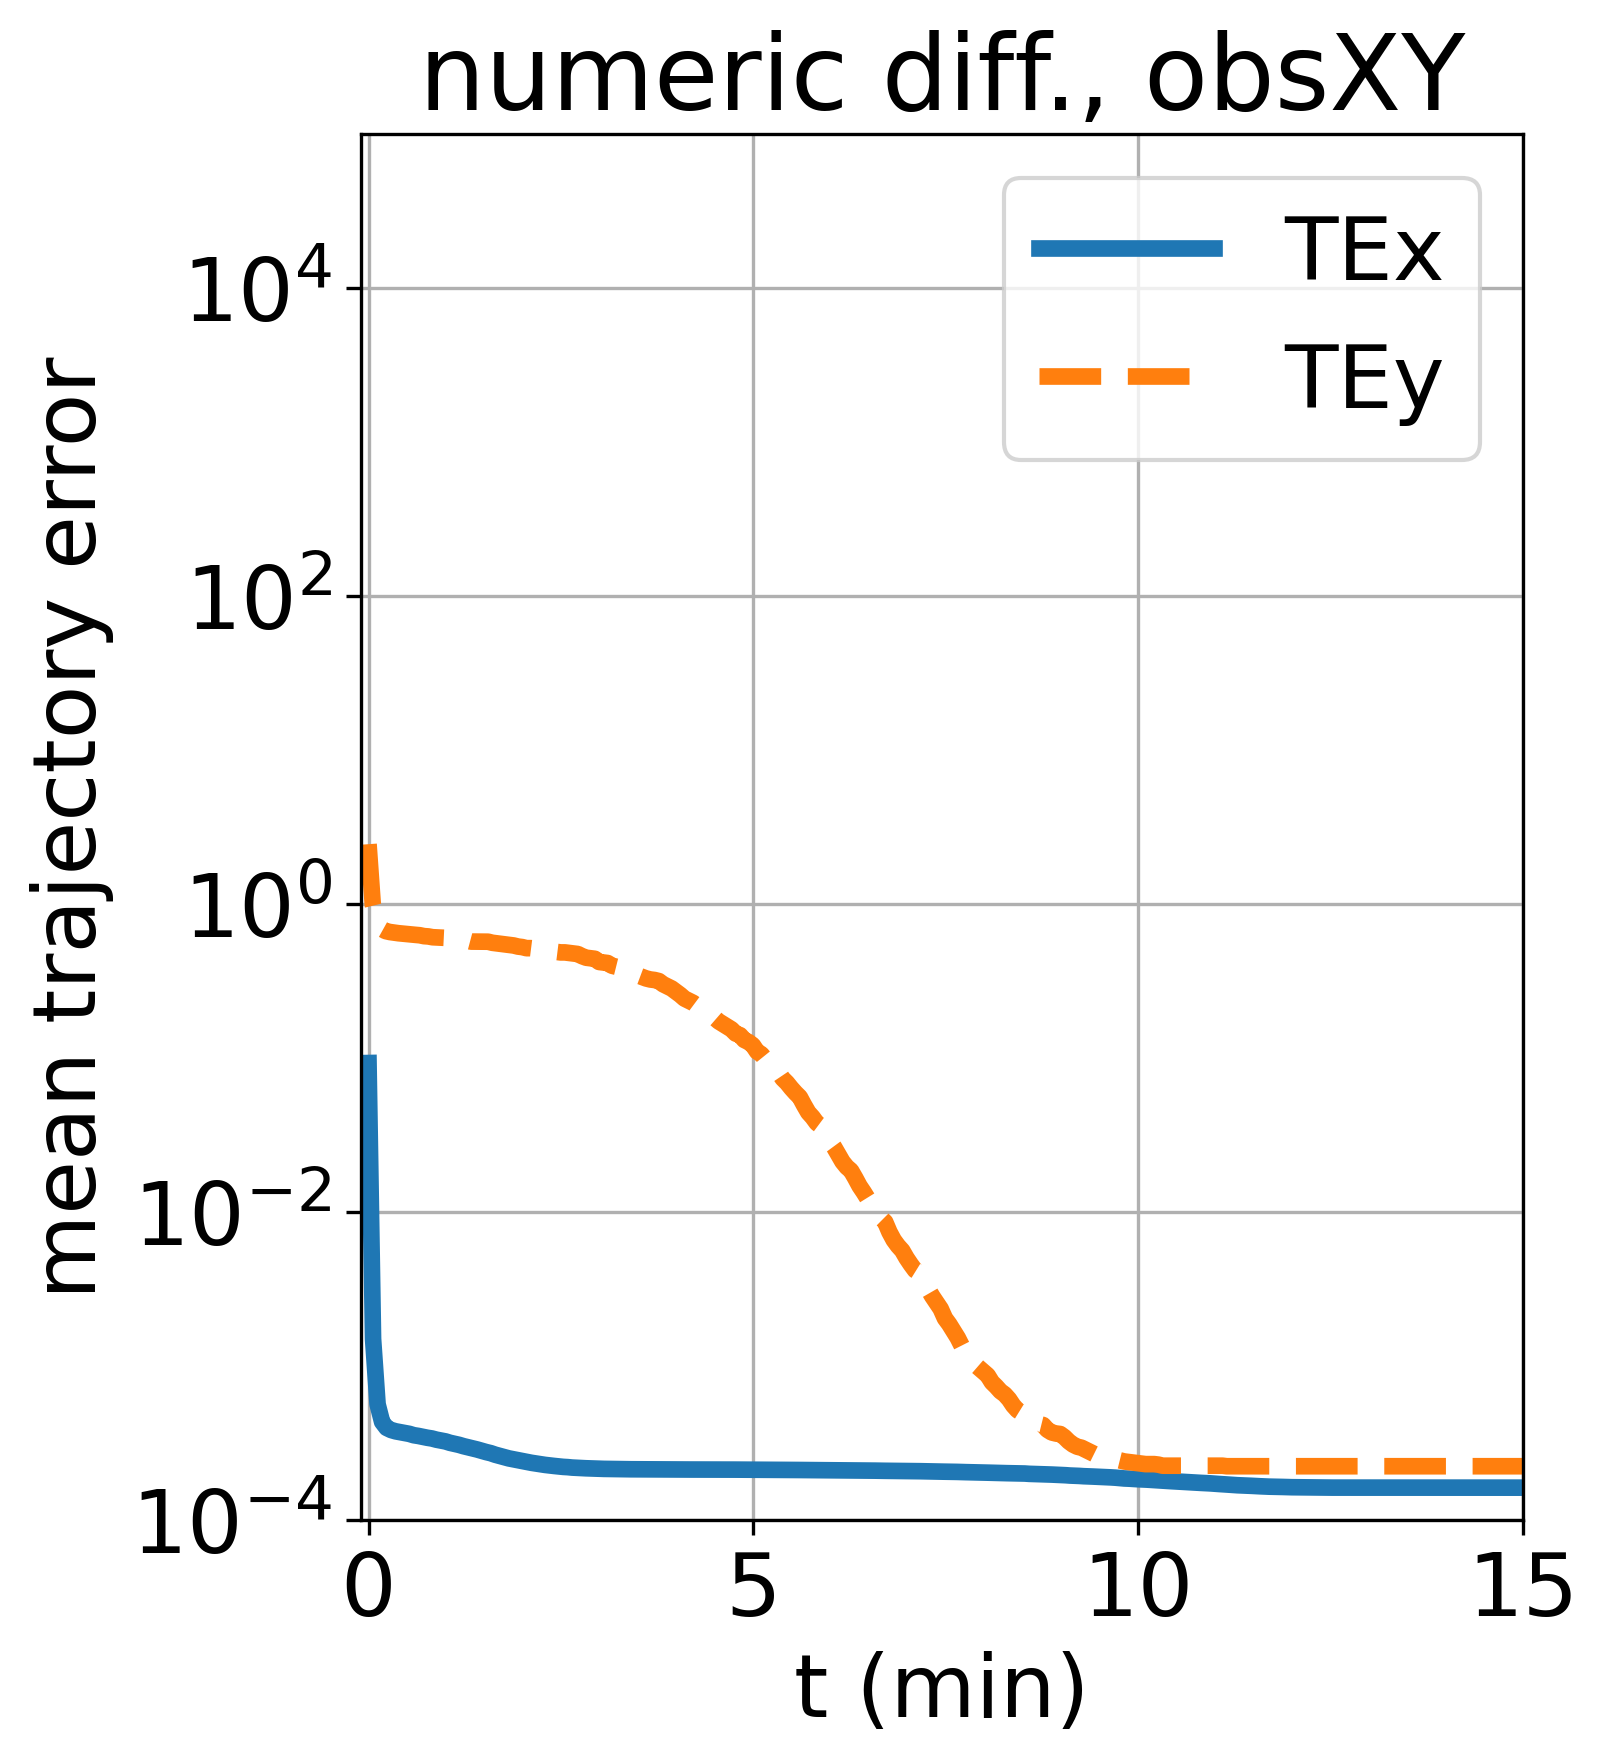

In [20]:
plt.rcParams.update({"font.size": 21})
fig = plt.figure(figsize=(5,6), dpi=300)
colors = ["C0", "C1"]
for i in range(Neq):
    t = np.array(list(range(len(curves[i]))))*meantimes[i]/60
    plt.plot(t, 10**curves[i], ["-", "--"][i], label=["TEx", "TEy"][i], lw=4, color=colors[i])
    #plt.plot([-5, 25], [thr_error[i], thr_error[i]], color=colors[i])
plt.yscale("log")
plt.legend()
plt.xlabel("t (min)")
plt.ylabel("mean trajectory error")
plt.xlim(-0.1, 15)
plt.ylim(10**-4, 10**5)
plt.title("numeric diff., obsXY")
plt.grid()
#plt.tight_layout()
plt.show()

In [64]:
fitted_params = np.array([0.999978656809846, -0.499907276211367, -0.999979301218477, 0.499908874573008])
true_params = np.array([1.0, -0.5, -1.0, 0.5])
print(np.sum(np.sqrt((true_params - fitted_params)**2)))
print((18+586)/60, "min")


0.00022589118730204083
10.066666666666666 min


2
161


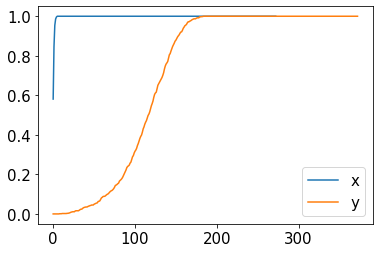

In [17]:
n95 = []
for i in range(Neq):
    plt.plot(succprob[i], label=["x","y","z"][i])
    n95 += [np.where(succprob[i]>0.95)[0][0]]
    print(n95[-1])
plt.legend()

x - 95% success probability:  2 models, 7 seconds
y - 95% success probability:  161 models, 536 seconds


Text(0.5, 1.0, 'ProGED: numeric derivatives, polynomial grammar')

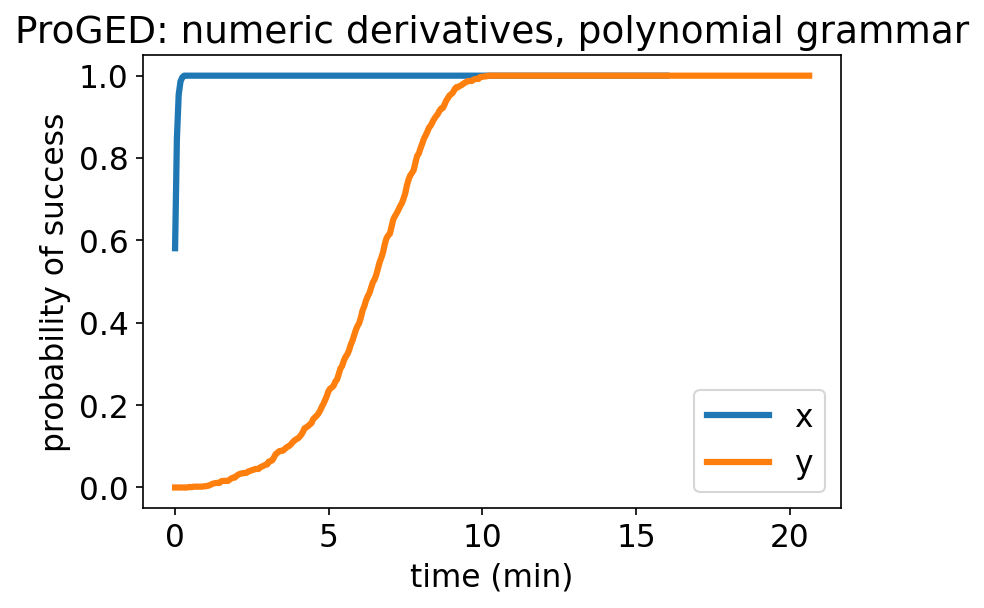

In [22]:
plt.figure(dpi=150)
for i in range(Neq):
    t = np.array(list(range(len(succprob[i]))))*meantimes[i]/60
    plt.plot(t, succprob[i], label=["x","y", "z"][i], lw=3)
    print(["x","y", "z"][i], "- 95% success probability: ", n95[i], "models,", round(meantimes[i]*n95[i]), "seconds")
plt.legend()
plt.xlabel("time (min)")
plt.ylabel("probability of success")
plt.title("ProGED: numeric derivatives, polynomial grammar")

In [17]:
lenmodels = [len(m) for m in models]

[477, 473, 0]

In [23]:
dfs = []
for i in range(Neq):
    df = pd.DataFrame()
    df["N"] = list(range(len(curves[i])))
    df["time"] = np.array(list(range(len(succprob[i]))))*meantimes[i]/60
    df["rrmse"] = curves[i]
    df["success-prob"] = succprob[i] 
    dfs += [df]
    df.to_csv("VDP_numdiff_eq"+str(i)+".csv", index=False)

In [92]:
fitted_params = np.array([0.999978656809846, -0.499907276211367, -0.999979301218477, 0.499908874573008])
def solutionf(t, x):
    return [fitted_params[0]*x[1], fitted_params[1]*x[0]**2*x[1] + fitted_params[2]*x[0] + fitted_params[3]*x[1]]

def solutionf_eql(t, x): 
    return [0.0144/(1.41 - 1.32*np.sin(2.86*t - 1.11*x[1] + 1.21)), 0.047/(1.488-1.45*np.sin(2.92*t-1.077*x[1]))]

inits = [-0.2, -0.8]

Yode, info = odeint(solutionf, inits, T,
                rtol = 1e-12,
                atol = 1e-12,
                tfirst=True,
                full_output=True)

errs = []
for i in range(Neq):
    errs += [np.sqrt(np.mean((Yode[:,i] - X[:,i])**2))/np.std(X[:,i])]
print("individual ReRMSE: ", errs)
print("total ReRMSE: ", np.sum(errs))

individual ReRMSE:  [0.0004965657479172534, 0.0005726947933023932]
total ReRMSE:  0.0010692605412196466


Text(0, 0.5, 'y')

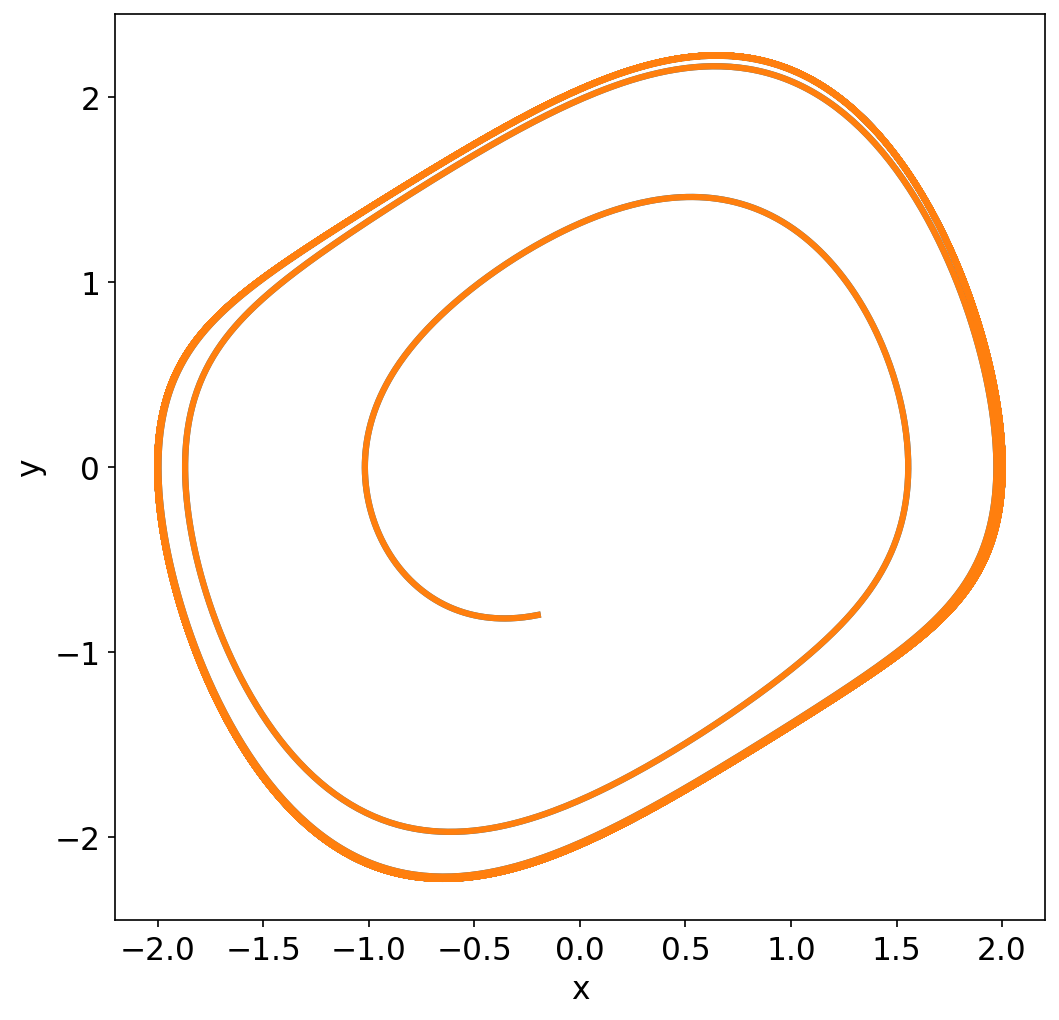

In [145]:
plt.rcParams.update({"font.size":15})
fig = plt.figure(figsize = (8,8), dpi=150)
plt.plot(data[:, 1], data[:, 2], lw=3)
plt.plot(Yode[:,0], Yode[:,1], lw=3)
plt.xlabel("x")
plt.ylabel("y")

In [20]:
import nltk
nltk.__version__

'3.5'

In [151]:
errs = [m.get_error() for m in models[1]]


nan

In [174]:
from ProGED.generators.grammar_construction import construct_production

if False:
    grammarstr = construct_production("E", ["E '+' F", "E '-' F", "F"], [0.15, 0.15, 0.7])
    grammarstr += construct_production("F", ["F '*' T", "T"], [0.2, 0.8])
    grammarstr += construct_production("T", ["'(' E ')'", "V", "'C'"], [0.2, 0.5, 0.3])
    grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])
if False:
    grammarstr = construct_production("P", ["P '+' M",  "M"], [0.4, 0.6])
    grammarstr += construct_production("M", ["T", "'C' '*' T"], [0.5, 0.5])
    grammarstr += construct_production("T", ["V '*' V", "V"], [1/3, 2/3])
    grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])
if True:
    grammarstr = construct_production("P", ["P '+' M", "M"], [0.4, 0.6])
    grammarstr += construct_production("M", ["V '*' V", "'-' V '*' V", "'C' '*' V"], [0.25, 0.25, 0.5])
    grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])


grammar = pg.GeneratorGrammar(grammarstr)
symbols = {"x": ["x","y","z"], "const":"C"}
np.random.seed(0)
models = pg.generate.generate_models(grammar, symbols, dimension=3, strategy_settings={"N":500, "max_repeat":100}) 

In [16]:
models[0][0].grammar

Grammar with 8 productions (start state = S)
    S -> S '+' R [0.4]
    S -> R [0.6]
    R -> T [0.6]
    R -> 'C' '*' F '(' T ')' [0.4]
    T -> T '*' V [0.4]
    T -> 'C' [0.6]
    V -> 'x' [0.5]
    V -> 'y' [0.5]

In [68]:
#min_i = np.min([len(mod) for mod in models])

npar = []
for n in range(10000):
    nc = 0
    for i in range(3):
        #nc += len(models[i][int(np.random.randint(0, min_i, size=1))].params)
        nc += len(models[int(np.random.randint(0, len(models), size=1))].sym_params)
        
    npar += [nc]
print("MC estimate, mean number of parameters in system: ", np.mean(npar))
print(np.min(npar), np.max(npar))
print(np.std(npar))

MC estimate, mean number of parameters in system:  3.3185
0 12
1.7222246514319786


In [147]:
exprs = [str(mod.expr) for mod in models]

In [177]:
for expr in exprs:
    if 'C0*x + C1*y' in expr:
        print(expr)

[C0*x + C1*y**2 + C2*z + x*y + z, x, C3*x + x**2]
[C0*x + C1*y + C2*z + y*z, C3*y**2 + C4*y, y*z]
[C0*x + C1*y + C2*z**2 + C3*z + x*z + y*z + z, x**2 + x, y]
[x, x*z, C0*x + C1*y]
[C0*x + C1*y + y, y*z, x]
[C0*x + C1*y, C2*y, z]
[C0*x + C1*y + C2*z + z**2 + z, z**2 + z, x]
[C0*x + C1*y + C2*z + y**2 + y + z, x*y, C3*x]
[C0*x + C1*y + C2*z, y, x]
[x, z, C0*x + C1*y + C2*z]
[C0*x + C1*y + x, x*z + y, C2*x]
[C0*x + C1*y*z + C2*y + y, C3*z + x*y + x, C4*y]
[x, x, C0*x + C1*y + 2*y]
[C0*x + C1*y, 2*z, C2*x]
[y*z + 2*y, C0*x + C1*y + C2*z + x*y + x*z, C3*x]
[C0*x + C1*y, C2*y*z + C3*y + x*y + y**2 + z, C4*x*y]
[C0*x + C1*y*z, x, C2*y*z]
[y, C0*x + C1*y, C2*x]
[z**2, C0*x + C1*y + x*z, x + z**2]


In [151]:
"C0*y + C1*z + x" in exprs

False

In [96]:
'x*y' in exprs

False

In [176]:
from nltk import Nonterminal
grammarstr = construct_production("P", ["P '+' M", "M"], [0.4, 0.6])
grammarstr += construct_production("M", ["V '*' V", "'-' V '*' V", "'C' '*' V"], [0.25, 0.25, 0.5])
grammarstr += construct_production("V", ["'x'", "'y'", "'z'"], [1/3, 1/3, 1/3])


grammar = pg.GeneratorGrammar(grammarstr)
grammar.count_coverage_external(Nonterminal("P"), 5)

0.9359999999999999

In [32]:
def cumargmax(a):
    m = np.maximum.accumulate(a)
    x = np.repeat(np.arange(a.shape[0])[:, None], a.shape[1], axis=1)
    x[1:] *= m[:-1] < m[1:]
    np.maximum.accumulate(x, axis=0, out=x)
    return x

In [38]:
errs = np.array([model.get_error() for model in models[0]])

In [51]:
mx = np.minimum.accumulate(errs)


In [53]:
errs

array([1.73883568e+02, 6.74496102e+08, 1.08799813e+09, 3.94064530e-04,
       2.70691692e+09, 4.02074820e-04, 1.54370855e+00, 2.53890794e+09,
       3.64397756e+09, 3.94285085e-04, 3.61226282e+08, 3.94517296e-04,
       3.82958838e-04, 1.78202727e+00, 1.50141074e+00, 1.79830520e+00,
       3.65224640e+08, 1.76633678e+00, 4.59890034e+05, 2.65272896e+09,
       1.49903136e+00, 1.97753515e+09, 5.60377373e-04, 1.90089288e+00,
       4.42711875e+09, 1.79063596e+00, 5.07742763e+05, 5.41062580e+08,
       1.54525918e+00, 2.29966825e+00, 2.76805446e-04, 3.93545120e-04,
       3.94197282e-04, 3.21661075e+09, 3.65399444e+08, 3.60957091e+09,
       3.60957091e+09, 2.34284966e+04, 2.91469454e+09, 1.28632924e+02,
       3.51926919e+09, 1.06540372e+09, 2.07935338e+09, 2.93184302e-04,
       2.08480463e+09, 2.08480463e+09, 3.37938827e-04, 2.01844290e+04,
       2.70955412e+09, 1.00000000e+08, 1.00000000e+08, 1.67636399e+09,
       1.55029519e+00, 2.20992449e+09, 2.20992450e+09, 3.93195865e-04,
      